In [1]:
from copy import deepcopy
import os
import time
import pydrake
from pydrake.all import (
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

Minimal grammar definition: each node has:
- a pose x
- a type name

A node class defines:
- its child type (by name or None)
- max # of children
- the geometric stop prob p (1. = always 1 child, 0. = infinite children)
- the region in which children will be produced (uniformly at random), in the frame of the node, in the form of an axis-aligned bounding box

E.g. object groups in plane:
- Root node produces object clusters and uniform random locations inside [0, 1]^2.
- Each cluster produces up points uniformly in a 0.1-length box centered at the cluster center.

In [2]:
# Minimal simple geometric-production-only grammar definition:
from collections import namedtuple
NodeDefinition = namedtuple("NodeDefinition",
    ["child_type",   # name of child type or None,
     "max_children", # max # of children
     "p",            # geometric keep-going probability
     "bounds"        # Generation bounds for children relative to node x
    ])
class Node():
    def __init__(self, type, x):
        self.x = x
        self.type = type
def sample_tree(grammar):
    # Given a grammar description as a dict of {node name: NodeDefinition} pairs,
    # sample a scene tree as a networkx DiGraph.
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = min(np.random.geometric(parent_def.p), parent_def.max_children)

        for k in range(n_children):
            child_x = parent.x + np.random.uniform(*parent_def.bounds)
            child = Node(parent_def.child_type, child_x)
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree

def get_observed_nodes(tree, observed_types):
    # Given a scene tree (nx.DiGraph) and a list of observed
    # node type names (list of strings), pulls out only nodes
    # in the  tree with matching type into a list of Nodes.
    return [n for n in tree if n.type in observed_types]

# Drawing utilities for trees.
def draw_tree(tree, draw_pos=True, with_labels=False):
    # Decide a coloring for the node tpyes.
    unique_types = sorted(list(set([n.type for n in tree])))
    n_types = len(unique_types)
    cm = plt.get_cmap("viridis")
    color_mapping = {unique_type: cm(float(k)/n_types) for k, unique_type in enumerate(unique_types)}
    if draw_pos:
        pos={node: node.x for node in tree}
    else:
        pos=None
    nx.draw_networkx(
        tree,
        labels={node: node.type for node in example_tree},
        with_labels=with_labels,
        pos=pos,
        node_color=[color_mapping[node.type] for node in tree],
        alpha=0.5
    )    
    plt.gca().set_xlim([-0.1, 1.1])
    plt.gca().set_ylim([-0.1, 1.1])
def draw_observed_nodes(nodes):
    tree = nx.Graph()
    tree.add_nodes_from(nodes)
    draw_tree(tree)

Text(0.5, 1.0, 'Observed nodes')

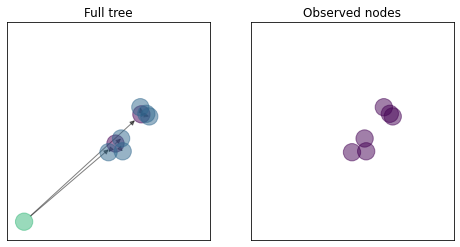

In [3]:
# Grammar implementing clusters of points in 2D.
cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    "cluster": NodeDefinition(child_type="point", p=0.25, max_children=3, bounds=[-np.ones(2)*0.05, np.ones(2)*0.05]),
    "root": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[np.ones(2)*0.05, np.ones(2)*0.95])
}
cluster_grammar_observed_types = ["point"]

np.random.seed(0)
example_tree = sample_tree(cluster_grammar)
observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))

plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.title("Observed nodes")

Mixed integer parsing strategy:
- Given the grammar description and a list of observed nodes, find the maximum likelihood parse tree from that grammar that explains that scene.
- Build the "super tree" of node types in the grammar: the scene tree (of types) that would result if every possible child node was produced.
- Add a binary variable to each node in the super tree, indicating whether that node is active in the parse of the given scene.
  - (Constraint: a node can't be active if its direct parent isn't active.)
- Add a 2D continuous variable to each node in the super tree to decide where that node is, if it's active in the parse of the scene.
  - (Constraint: a child must be in a legal position relative to the parent, i.e. within axis-aligned bounds of the parent position as a linear constraint.)
- Add an edge from every observed node to every node in the super tree that could have produced it, with a binary variable per edge indicating which super-tree node is explaining which observed node.
  - (Constraint: each observed node is explained by exactly one node in the tree.)
  - (Constraint: each observed "type" in the super tree is active only if it's explaining an observed node, and explains at most one observed node.)
  - (Constraint: if a super tree node is explaining an observed node, its position is constrained to be equal to the observed node position.)

Text(0.5, 1.0, 'Super tree for cluster grammar')

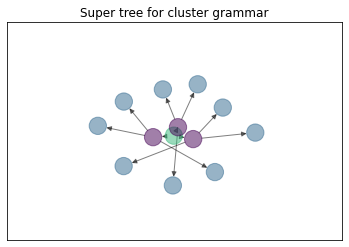

In [4]:
def make_super_tree(grammar):
    # Same logic as sampling a tree, but instead takes *all*
    # choices (but doesn't bother with sampling x).
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = parent_def.max_children

        for k in range(n_children):
            child = Node(parent_def.child_type, np.zeros(2))
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree
super_tree = make_super_tree(cluster_grammar)
draw_tree(super_tree, draw_pos=False)
plt.xlim([-2., 2.])
plt.ylim([-2., 2.])
plt.title("Super tree for cluster grammar")

In [5]:
# Make a super tree and observed node set, which we'll modify to organize our optimization variables.

def infer_mle_tree(grammar, observed_nodes, observed_node_types, verbose=False, optimize_positions=True):
    super_tree = make_super_tree(grammar)
    observed_nodes = deepcopy(observed_nodes)

    prog = MathematicalProgram()

    # Every node gets a binary variable to indicate
    # whether it's active or node. This is equivalent to a
    # binary variable on the incoming edge for the node.
    active_vars = prog.NewBinaryVariables(len(super_tree.nodes), "nodes_active")
    for k, node in enumerate(super_tree.nodes):
        node.active = active_vars[k]

    # Every node gets a position, which is continuous inside the 2D unit box.
    if optimize_positions:
        for k, node in enumerate(super_tree.nodes):
            node.x_optim = prog.NewContinuousVariables(2, "%s_%d_x" % (node.type, k))
            prog.AddBoundingBoxConstraint(0., 1., node.x_optim)
            if node.type == "root":
                # Fix root since we know it should be at origin
                prog.AddBoundingBoxConstraint(0., 0., node.x_optim)


    # For each node in the super tree, add relationships between the parent
    # and that node.
    for parent_node in super_tree:
        children = list(super_tree.successors(parent_node))
        child_actives = [c.active for c in children]
        parent_node.child_actives = child_actives

        # Children active requires parent active.
        for child_active in child_actives:
            prog.AddLinearConstraint(parent_node.active >= child_active)

        # Geometric node child ordering to reduce duplicate parse: a child can
        # only be active if the previous child is also active.
        for k in range(len(child_actives) - 1):
            # child_{k+1} implies child_k
            # i.e. child_k >= child_{k+1}
            prog.AddLinearConstraint(child_actives[k] >= child_actives[k+1])

        # Add negative log prob cost for geometric activation: each additional
        # node activation incurs a penalty based on the geometric stopping probability.
        # (I'm discarding the probability that we terminated, since we assume that we
        # always terminated. TODO: I'm not sure if that's true, since we truncate at some
        # max # of groups.)
        #termination_nll = -np.log(p)
        p = grammar[parent_node.type].p
        for k in range(len(child_actives)):
            prog.AddLinearCost(child_actives[k] * (1. - p))
        # The geometric process we used (np.random.geometric) is only supported
        # on k=1, ..., so constrain that the # of active children must be
        # nonzero if this node is on.
        if len(child_actives) > 0:
            prog.AddLinearConstraint(sum(child_actives) >= parent_node.active)

        if optimize_positions and len(children) > 0:
            # The children are uniformly distributed inside a box relative
            # to the parent, so the log prob of this node's position is
            # just 1 / area.
            lb, ub = grammar[parent_node.type].bounds
            nll = -np.log(1. / np.prod(ub - lb))
            for child_active in child_actives:
                prog.AddLinearCost(child_active * nll)

            # However, the child needs to be constrained to be within
            # the specified bounds of the parent position if the child
            # is active.
            for child in children:
                # I want this to work:
                # S = VPolytope.MakeBox(lb, ub)
                # S.AddPointInSetConstraints(prog, parent_node.x_optim - child.x_optim)
                # but it's not happy. What gives?
                for i in range(2):
                    prog.AddLinearConstraint(child.x_optim[i] >= parent_node.x_optim[i] + lb[i])
                    prog.AddLinearConstraint(child.x_optim[i] <= parent_node.x_optim[i] + ub[i])


    # For each observed node, add a binary variable for each possible
    # correspondence to a node in the observed set, where an active correspondence
    # forces the corresponded node to be the same position as the observed node.
    for n in super_tree:
        # (first prep some bookkeeping)
        n.outgoings = []
    for observed_node in observed_nodes:
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        source_actives = prog.NewBinaryVariables(len(possible_sources), observed_node.type + "_sources")

        # Store these variables
        observed_node.source_actives = source_actives
        for k, n in enumerate(possible_sources):
            n.outgoings.append(source_actives[k])

        # Each observed node needs exactly one explaining input.
        prog.AddLinearEqualityConstraint(sum(source_actives) == 1)
        
        if optimize_positions:
            for k, node in enumerate(possible_sources):
                M = 1. # Should upper bound positional error in any single dimension
                # When correspondence is active, force the node to match the observed node.
                # Otherwise, it can vary within a big M of the observed node.
                for i in range(2):
                    prog.AddLinearConstraint(node.x_optim[i] <= observed_node.x[i] + 1E-6 + (1. - source_actives[k]) * M)
                    prog.AddLinearConstraint(node.x_optim[i] >= observed_node.x[i] - 1E-6 - (1. - source_actives[k]) * M)

    # Go back and make sure no node in the super tree is being used
    # to explain more than one observed node, and that the "observed"
    # nodes are only active if they are explaining something.
    for node in super_tree:
        if node.type in observed_node_types:
            if len(node.outgoings) > 0:
                prog.AddLinearConstraint(sum(node.outgoings) <= 1)
                prog.AddLinearConstraint(node.active == sum(node.outgoings))
            else:
                # Never observed this type, so this node can't be active.
                prog.AddLinearConstraint(node.active == 0)
            
    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    result = solver.Solve(prog, None, options)
    if verbose:
        print("Optimization success?: ", result.is_success())
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    TreeInferenceResults = namedtuple("TreeInferenceResults", ["optim_result", "super_tree", "observed_nodes"])
    return TreeInferenceResults(result, super_tree, observed_nodes)
    

observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
inference_results = infer_mle_tree(
    cluster_grammar, observed_nodes, cluster_grammar_observed_types,
    verbose=True, optimize_positions=True
)

Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Jul 16 12:07:49 2021




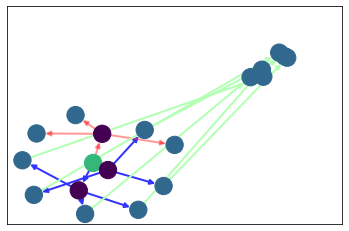

In [6]:
# Draws the super-tree to the left
def draw_mle_tree_corrs(inference_results):
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes
    result = inference_results.optim_result

    drawing_tree = super_tree.copy()
    for observed_node in observed_nodes:
        drawing_tree.add_node(observed_node)
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        if not np.isclose(np.sum(result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node not explained by MLE sol.")
        for k, s in enumerate(possible_sources):
            if result.GetSolution(observed_node.source_actives[k]):
                drawing_tree.add_edge(s, observed_node)

    pos = nx.spring_layout(super_tree)
    # Shift super tree drawing entirely to the negative unit box
    ur = np.max(np.array(list(pos.values())), axis=0)
    ll = np.min(np.array(list(pos.values())), axis=0)
    for k, x in pos.items():
        pos[k] = (x - ll)/(ur - ll) - 1.
    # Add in positions for observed nodes, which should be in positive unit box.
    for n in observed_nodes:
        pos[n] = n.x

    edge_colors = []
    for parent, child in drawing_tree.edges:
        if hasattr(child, "active"):
            # Child is in supertree
            active = result.GetSolution(child.active)
            if active:
                assert result.GetSolution(parent.active)
                edge_colors.append([0.2, 0.2, 1., 1.])
            else:
                edge_colors.append([1.0, 0.2, 0.2, 0.5])
        else:
            # When we built drawing tree, we only added the
            # active + explaining node for each observed node.
            assert result.GetSolution(parent.active)
            edge_colors.append([0.7, 1.0, 0.7, 1.0])
    unique_types = sorted(list(set([n.type for n in drawing_tree])))
    n_types = len(unique_types)
    cm = plt.get_cmap("viridis")
    color_mapping = {unique_type: cm(float(k)/n_types) for k, unique_type in enumerate(unique_types)}
    nx.draw_networkx(
        drawing_tree,
        with_labels=False,
        pos=pos,
        node_color=[color_mapping[node.type] for node in drawing_tree],
        edge_color=edge_colors,
        width=2
    )
    plt.gca().set_xlim([-1.1, 1.1])
    plt.gca().set_ylim([-1.1, 1.1])
draw_mle_tree_corrs(inference_results)

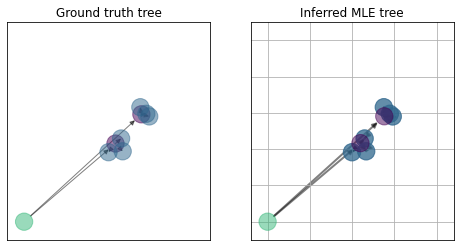

In [7]:
# Draws the optimized tree in the optimized positions.
# Draws the super-tree to the left
def draw_mle_tree(inference_results):
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes
    result = inference_results.optim_result

    drawing_tree = nx.DiGraph()

    for observed_node in observed_nodes:
        copy_node = deepcopy(observed_node)
        copy_node.type = observed_node.type
        drawing_tree.add_node(copy_node)
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        if not np.isclose(np.sum(result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)
        for k, s in enumerate(possible_sources):
            if result.GetSolution(observed_node.source_actives[k]):
                drawing_tree.add_node(s)
                drawing_tree.add_edge(s, copy_node)

    for node in super_tree:
        if result.GetSolution(node.active):
            drawing_tree.add_node(node)
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert result.GetSolution(parent.active)
                drawing_tree.add_edge(parent, node)

    pos = {}
    for n in drawing_tree:
        if hasattr(n, "active"):
            pos[n] = result.GetSolution(n.x_optim)
        else:
            pos[n] = n.x


    unique_types = sorted(list(set([n.type for n in drawing_tree])))
    n_types = len(unique_types)
    cm = plt.get_cmap("viridis")
    color_mapping = {unique_type: cm(float(k)/n_types) for k, unique_type in enumerate(unique_types)}
    nx.draw_networkx(
        drawing_tree,
        with_labels=False,
        pos=pos,
        alpha=0.5,
        node_color=[color_mapping[node.type] for node in drawing_tree],
        width=2,
        #node_size = [unique_types.index(node.type)*100 for node in drawing_tree]
    )
    plt.gca().set_xlim([-0.1, 1.1])
    plt.gca().set_ylim([-0.1, 1.1])


plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Ground truth tree")
plt.subplot(1, 2, 2)
draw_mle_tree(inference_results)
plt.title("Inferred MLE tree")
plt.grid(True)

0: Inferred for 6 node scene in 0.039030 secs
1: Inferred for 2 node scene in 0.021107 secs
2: Inferred for 2 node scene in 0.020566 secs
3: Inferred for 6 node scene in 0.092754 secs
4: Inferred for 6 node scene in 0.048651 secs
5: Inferred for 3 node scene in 0.025513 secs
6: Inferred for 8 node scene in 0.063179 secs
7: Inferred for 3 node scene in 0.026410 secs
8: Inferred for 6 node scene in 0.050449 secs
9: Inferred for 1 node scene in 0.018938 secs
10: Inferred for 7 node scene in 0.055410 secs
11: Inferred for 3 node scene in 0.027044 secs
12: Inferred for 3 node scene in 0.025587 secs
13: Inferred for 7 node scene in 0.057019 secs
14: Inferred for 6 node scene in 0.038791 secs


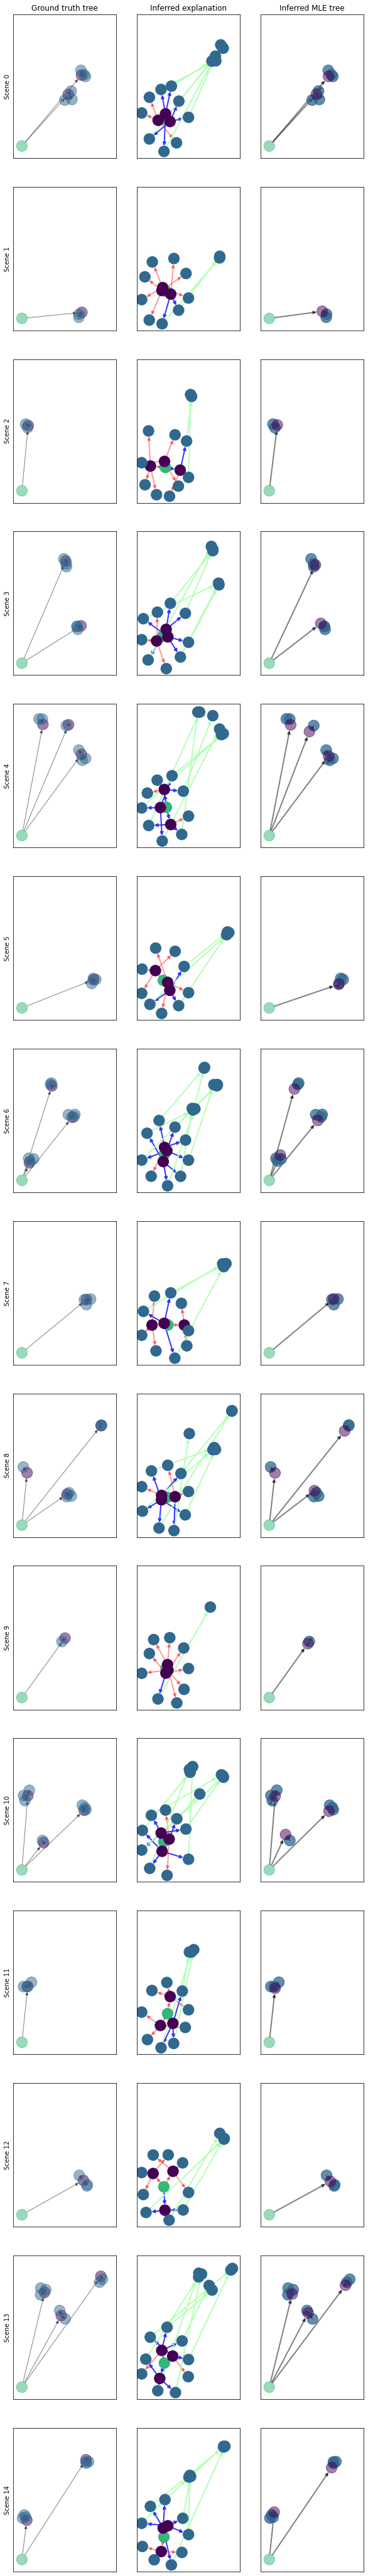

In [8]:
# Generate + infer on a bunch of trees.
N = 15
plt.figure().set_size_inches(10, N*5)
for k in range(N):
    np.random.seed(k)
    plt.subplot(N, 3, 3*k+1)
    example_tree = sample_tree(cluster_grammar)
    observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
    draw_tree(example_tree)
    if k == 0:
        plt.title("Ground truth tree")
    plt.ylabel("Scene %d" % k)
    start_time = time.time()
    inference_results = infer_mle_tree(cluster_grammar, observed_nodes, cluster_grammar_observed_types, verbose=False)
    print("%d: Inferred for %d node scene in %f secs" % (k, len(observed_nodes), time.time() - start_time))
    if not inference_results.optim_result.is_success():
        print("WARN: Failed optimization.")
    
    plt.subplot(N, 3, 3*k+2)
    draw_mle_tree_corrs(inference_results)
    if k == 0:
        plt.title("Inferred explanation")
    
    plt.subplot(N, 3, 3*k+3)
    draw_mle_tree(inference_results)
    if k == 0:
        plt.title("Inferred MLE tree")
